## Curvas de resposta do controle do gimbal

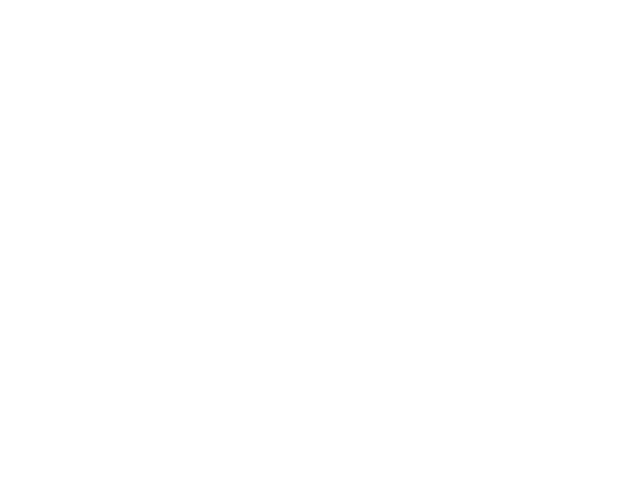

In [2]:
from numpy import pi
import numpy as np
from numpy import array
from matplotlib import pyplot as plt
import matplotlib as mpl
import mplcursors
%matplotlib widget


from matplotlib import cycler
colors = cycler('color',
                ['#3388BB','#EE6666', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', prop_cycle=colors)
plt.rc('grid', color='#00000020', linestyle='dashed')
# plt.rc('xtick', direction='in', color='gray')
# plt.rc('ytick', direction='in', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=1)

# mpl.style.use('seaborn')
#preferencia dos graficos
# plt.rcParams['lines.linewidth'] = 1

plt.tight_layout()

#função para mapear 0 - 2pi para -pi - pi
def f(x:float):
    if x > pi:
        return x-2*pi
    elif x < -pi:
        return x+2*pi
    else:
        return x
#vetorizar a função para aplicar diretamente no array
ang_adj = np.vectorize(f)


#função para mapear 0 - 2pi para -pi - pi
def r2d(x:float):
    return 180*x/pi
#vetorizar a função para aplicar diretamente no array
degree = np.vectorize(r2d)

#cortar curvas usando valores de tempo
def cut(t,low,up):
    if (t[0]>low or t[-1]<up):
        raise Exception(f"Faixa incorreta [{t[0]},{t[-1]}] [{low},{up}]")
    dt = (t[-1]-t[0])/t.size
    i = int((low-t[0])//dt)
    j = int((up-t[0])//dt)
    return i,j

#encontrar o inicio dos testes (quando ref muda para 0.5)
def find_start(ref) -> int:
    return ref.tolist().index(0.5)

#encontrar o ponto de regime permanente, passa a curva e os limites
def find_ss(vet, upper,lower):
    i = vet.size-1
    while vet[i] <upper and vet[i] > lower and i != -1:
        i-=1
    return i

def IDA(e,t):
    n = e.size
    s = 0
    i=0;
    while i < n -1:
        s+= abs((e[i] - e[i-1])/(t[i]-t[i+1]))
        i+=1
    return s/(t[-1]-t[0])


### Rapida curva do tracking de cores com mudança na referencia

São feitos 3 plots comparando as referencias aos valores de posição do objeto na tela e da rotação.

O video da resposta esta gravado:

In [3]:
from IPython.display import Video
Video("cores_2.mp4")

[Text(0, 0.5, 'Rotação (rad)')]

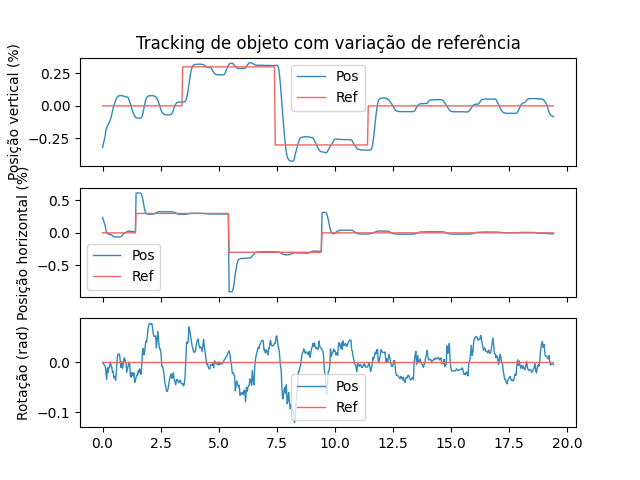

In [4]:
file = 'curva_cores_ref.txt'

[x1, y1, ang1, x2, y2, ang2, t] = np.loadtxt(file, unpack=True)
# y = data[:,1]
t = t - t[0]  # inicia tempo com 0

x1 = x2+x1
y1 = y2+y1

fig,(ax,ay,an) = plt.subplots(3)
mplcursors.cursor(hover=True)
ax.plot(t, y1, t, y2)
ax.set_title('Tracking de objeto com variação de referência')
ax.legend(['Pos','Ref'])
ax.set(ylabel='Posição vertical (%)')
ax.label_outer()
# ay.set_title('Resposta da camera em tracking de objeto')
ay.plot(t,x1,t,x2)
ay.legend(['Pos','Ref'])
ay.label_outer()
ay.set( ylabel='Posição horizontal (%)')

an.plot(t,ang1,t,ang2)
an.legend(['Pos','Ref'])
an.set( ylabel='Rotação (rad)')
# ax.show()


### Curvas sem feedback da camera

É possivel fazer 3 testes com o controle do gimbal sem a camera
1. base parada e mudança de setpoint.
   Dados de 3 eixos, referencia e saida

2. base se movendo(disturbio) e setpoint fixo
3. disturbio + setpoint variavel

## CURVA ZERO

Primeiro mostrar o gimbal parado e como o PI junto com o zona morta e a folga atrapalham

Os testes mostram o erro em regime depois de um disturbio, como e sem o limitação no integrador

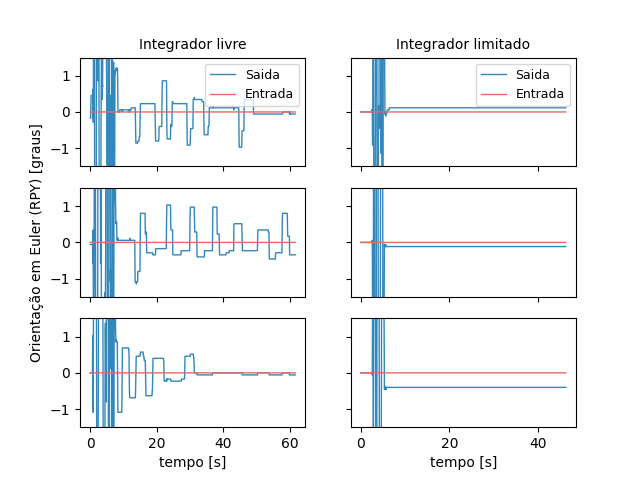

In [5]:
fig,ax = plt.subplot_mosaic([['yi','y'],['pi','p'],['ri','r']])

#como não interessa o disturbio anterior vamos focar na escala do erro em regime permanente
for a in ax:
    ax[a].set_ylim(ymin=-1.5,ymax=1.5)

file = 'curvas_1/parado_integrador_livre.txt'

#roll pitch yaw
[r, p, y, r2, p2, y2, t] = np.loadtxt(file, unpack=True)
t = t - t[0]  # inicia tempo com 0

# nesse caso a referencia começou diferente de 0, mas para facilitar a visualização vamos trazer tudo para zero
r = r - r2[0]
r2 = r2 - r2[0]
p = p - p2[0]
p2 = p2 - p2[0]
y = y - y2[0]
y2 = y2 - y2[0]

r = ang_adj(r)

ags = [r, p, y, r2, p2, y2]
[r, p, y, r2, p2, y2] = degree(ags)

ax['yi'].set_title('Integrador livre',fontsize='10')
ax['yi'].plot(t, y, t, y2)
ax['yi'].legend(['Saida','Entrada'],fontsize='9')
ax['yi'].label_outer()

# ax['pi'].set(ylabel='Posição Angular [graus]')
ax['pi'].set(ylabel='Orientação em Euler (RPY) [graus]')
ax['pi'].plot(t,p,t,p2)
ax['pi'].label_outer()

ax['ri'].plot(t,r,t,r2)
ax['ri'].set(xlabel='tempo [s]')

#-----------------------------------------------------

file = 'curvas_1/parado_integrador_limitado.txt'


[r, p, y, r2, p2, y2, t] = np.loadtxt(file, unpack=True)
t = t - t[0]  # inicia tempo com 0

# nesse caso a referencia começou diferente de 0, mas para facilitar a visualização vamos trazer tudo para zero
r = r - r2[0]
r2 = r2 - r2[0]
p = p - p2[0]
p2 = p2 - p2[0]
y = y - y2[0]
y2 = y2 - y2[0]

r = ang_adj(r)

ags = [r, p, y, r2, p2, y2]
[r, p, y, r2, p2, y2] = degree(ags)

ax['y'].set_title('Integrador limitado',fontsize='10')
ax['y'].plot(t,y,t,y2)
ax['y'].legend(['Saida','Entrada'],fontsize='9')
ax['y'].label_outer()


ax['p'].plot(t,p,t,p2)
ax['p'].label_outer()

ax['r'].plot(t,r,t,r2)
ax['r'].set(xlabel='tempo [s]')
ax['r'].label_outer()



In [6]:
#salvar
fig.set_size_inches(7,5)
# plt.savefig("imagens/integrador_limit.svg")

Agora com integrador limitado

[Text(0, 0.5, 'Pitch [deg]')]

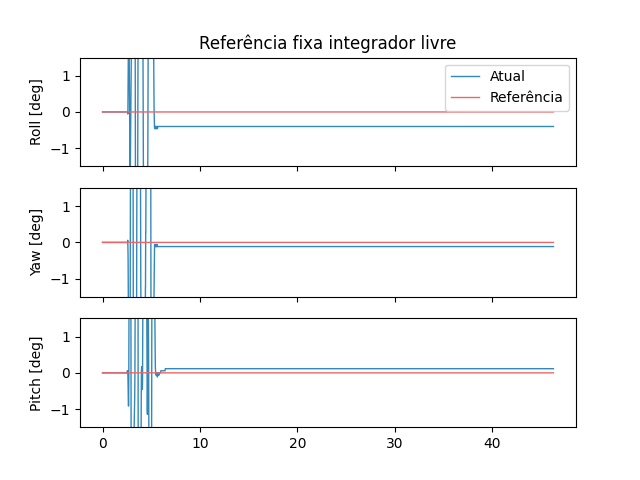

In [7]:
file = 'curvas_1/parado_integrador_limitado.txt'

#roll pitch yaw
[r, p, y, r2, p2, y2, t] = np.loadtxt(file, unpack=True)
t = t - t[0]  # inicia tempo com 0

# nesse caso a referencia começou diferente de 0, mas para facilitar a visualização vamos trazer tudo para zero
r = r - r2[0]
r2 = r2 - r2[0]
p = p - p2[0]
p2 = p2 - p2[0]
y = y - y2[0]
y2 = y2 - y2[0]

r = ang_adj(r)

ags = [r, p, y, r2, p2, y2]
[r, p, y, r2, p2, y2] = degree(ags)

fig,(ar,ap,ay) = plt.subplots(3)

#como não interessa o disturbio anterior vamos focar na escala do erro em regime permanente
ar.set_ylim(ymin=-1.5,ymax=1.5)
ap.set_ylim(ymin=-1.5,ymax=1.5)
ay.set_ylim(ymin=-1.5,ymax=1.5)

ar.plot(t, r, t, r2)
ar.set_title('Referência fixa integrador livre')
ar.legend(['Atual','Referência'])
ar.set(ylabel='Roll [deg]')
ar.label_outer()
# ay.set_title('Resposta da camera em tracking de objeto')
ap.plot(t,p,t,p2)
# ap.legend(['Pos','Ref'])
ap.set( ylabel='Yaw [deg]')
ap.label_outer()

ay.plot(t,y,t,y2)
# ay.legend(['Pos','Ref'])
ay.set( ylabel='Pitch [deg]')

## Primeira Curva

Mudança na referência da orientação


## Metodo da sensibilidade limite

Tabela de Ziegler e Nichols

|     | Kp     | Ti     | Td       |
|-----|--------|--------|----------|
| PID | 0.6Kcr | 0.5Pcr | 0.125Pcr |

Os teste da sensibilidade limite foram feitos com cada motor, enquanto os outros motores se mantinham parados, ou melhor, inercia constante.

[Text(0.5, 0, 'tempo [s]')]

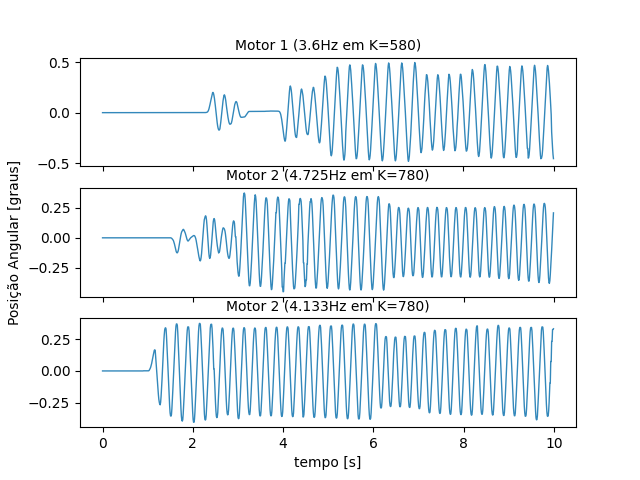

In [8]:


file = 'curvas_1/sensiblimit_1.txt'

#roll pitch yaw
[r, p, y, r2, p2, y2, t] = np.loadtxt(file, unpack=True)
t = t - t[0]  # inicia tempo com 0
r = ang_adj(r)
r = r - r2[0]
i,j =cut(t,0,10)

fig,ax= plt.subplots(3)
ax[0].plot(t[i:j],r[i:j])
ax[0].set_title("Motor 1 (3.6Hz em K=580)",fontsize="10")
ax[0].label_outer()
#frequencia em KP 580 = 3.6Hz


file = 'curvas_1/sensiblimit_2.txt'

[r, p, y, r2, p2, y2, t] = np.loadtxt(file, unpack=True)
t = t - t[0]  # inicia tempo com 0
p = p - p2[0]
# p= degree(p)
i,j =cut(t,0,10)
# fig,ax= plt.subplots()
ax[1].plot(t[i:j],p[i:j])
ax[1].set(ylabel="Posição Angular [graus]")
ax[1].set_title("Motor 2 (4.725Hz em K=780)",fontsize="10")
ax[1].label_outer()

#frequencia em KP 780 = 4.725Hz


file = 'curvas_1/sensiblimit_3.txt'

[r, p, y, r2, p2, y2, t] = np.loadtxt(file, unpack=True)
t = t - t[0]  # inicia tempo com 0
y = y - y2[0]
# p= degree(p)
i,j =cut(t,0,10)
# fig,ax= plt.subplots()
ax[2].plot(t[i:j],y[i:j])
ax[2].set_title("Motor 2 (4.133Hz em K=780)",fontsize="10")
ax[2].set(xlabel="tempo [s]")

#frequencia em KP 780 = 4.133Hz


In [9]:
np.set_printoptions(suppress=True)

Pcr = array([0.2777,0.2116,0.2419])
Kcr = array([580,780,780])

Kp = 0.6*Kcr
Ti = 0.5*Pcr
Td = 0.125*Pcr

a = [Pcr,Kcr,Kp,Ti,Td]
# print(np.transpose(a))
print(a)

#PD

Kp = 0.8*Kcr
Ti = 0*Pcr
Td = 0.125*Pcr
a = [Pcr,Kcr,Kp,Ti,Td]
# print(np.transpose(a))
print(a)

[array([0.2777, 0.2116, 0.2419]), array([580, 780, 780]), array([348., 468., 468.]), array([0.13885, 0.1058 , 0.12095]), array([0.0347125, 0.02645  , 0.0302375])]
[array([0.2777, 0.2116, 0.2419]), array([580, 780, 780]), array([464., 624., 624.]), array([0., 0., 0.]), array([0.0347125, 0.02645  , 0.0302375])]


Valores encontrados de cada motor foram:

|Motor|Pcr|Kcr|-|Kp|Ti|Td|
|-----|---|---|-|-|-|-|
|1|0.2777|580|-|348|0.1388|0.0347|
|2|0.2116|780|-|468|0.1058|0.0226|
|3|0.2419|780|-|468|0.1209|0.0302|

Sem overshoot

|Motor|Pcr|Kcr|-|Kp|Ti|Td|
|-----|---|---|-|-|-|-|
|1|0.2777|580|-|116|0.1388|0.091641|
|2|0.2116|780|-|156|0.1058|0.069828|
|3|0.2419|780|-|156|0.1209|0.079827|

Comparativo entre a sintonia com ziglier Nichols e um pequeno ajuste, ou a remoção do integrativo

-13.349916626548183 3.686
-4.698253920072751 3.679000000000002


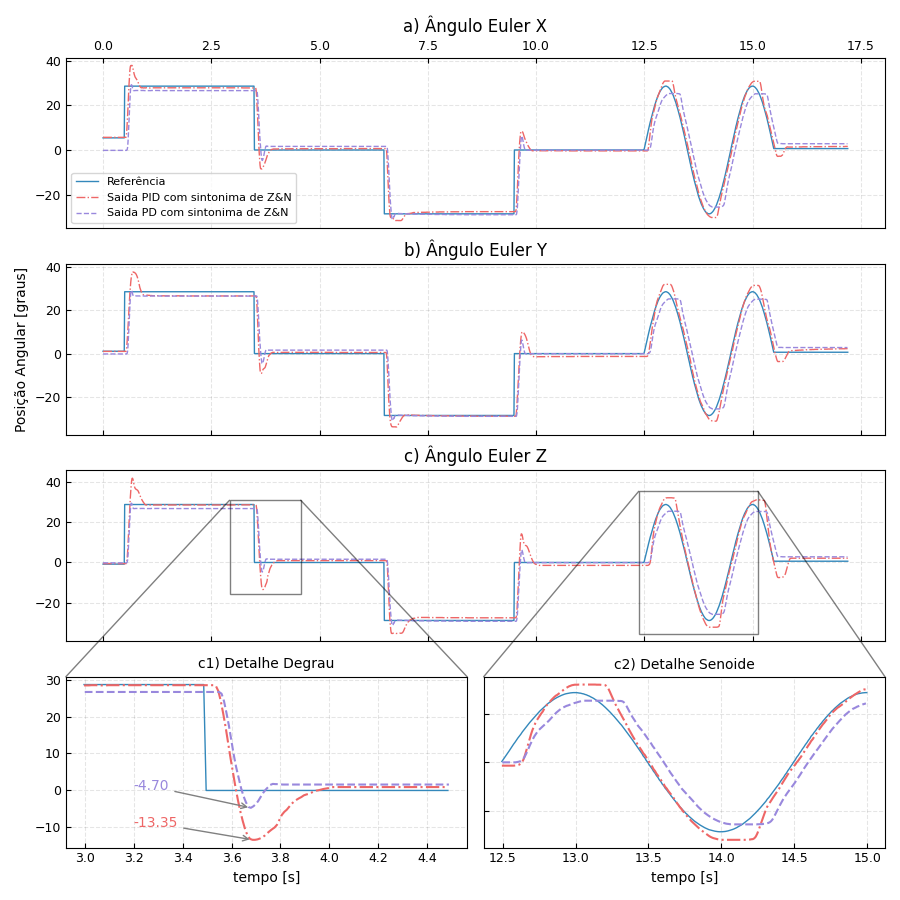

In [10]:
mosaic = [['yaw','yaw'],
['pit','pit'],
['rol','rol'],
['zoom_deg','zoom_sin']]

fig,ax = plt.subplot_mosaic(mosaic)
fig.set_size_inches(9,9)

ax['yaw'].set(title='a) Ângulo Euler X')
ax['yaw'].tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

ax['pit'].set(ylabel='Posição Angular [graus]', title='b) Ângulo Euler Y')
# ax['pit'].label_outer()

ax['rol'].set(title='c) Ângulo Euler Z')

ax['zoom_deg'].set_title('c1) Detalhe Degrau',fontsize="10")
ax['zoom_deg'].set(xlabel='tempo [s]')
ax['zoom_sin'].set_title('c2) Detalhe Senoide',fontsize="10")
ax['zoom_sin'].set(xlabel='tempo [s]')

for a in ax:
    ax[a].tick_params(direction='in', labelsize='9')
    ax[a].grid(which='major', alpha=0.1)
    ax[a].label_outer()

#------------------------------------------------------------------
file = 'curvas_1/orient_ref_only_Z_N.txt'

#roll pitch yaw
[r, p, y, r2, p2, y2, t] = np.loadtxt(file, unpack=True)

#alguns ponto antes da primeira mudança de ref
start_point = find_start(r2) - 50
t = t - t[start_point]  # inicia tempo com 0
i,j = cut(t,0,17.2)

[r, p, y, r2, p2, y2] = degree([r, p, y, r2, p2, y2])

ax['yaw'].plot(t[i:j],y2[i:j],'-')
ax['yaw'].plot(t[i:j],y[i:j],'-.')

ax['pit'].plot(t[i:j],p2[i:j],'-')
ax['pit'].plot(t[i:j],p[i:j],'-.')

ax['rol'].plot(t[i:j],r2[i:j],'-')
ax['rol'].plot(t[i:j],r[i:j],'-.',)


i,j = cut(t,3,4.5)
ax['zoom_deg'].plot(t[i:j],r2[i:j])
ax['zoom_deg'].plot(t[i:j],r[i:j],'-.', linewidth=1.5)

#------------------------------------------------------------------
#infos
#sobre sinal
iss = np.argmin(r[i:j]) - 0
ss = (r[i:j])[iss]
tss = (t[i:j])[iss]
print(ss, tss)
# tempo de assentamento

#instante de acentamente
its = find_ss(r[i:j],2,-2)
#instante da mudança de referencia
iref = r2[i:j].tolist().index(0)
#diferença
ts = t[its]-t[iref]


ax['zoom_deg'].annotate(f'{ss:.2f}',
            xy=(tss, ss),xycoords='data',
            xytext=(3.2,-10),textcoords='data', color='#EE6666',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color='grey'))

#------------------------------------------------------------------

i,j = cut(t,12.5,15)
ax['zoom_sin'].plot(t[i:j],r2[i:j])
ax['zoom_sin'].plot(t[i:j],r[i:j],'-.', linewidth=1.5)


file = 'curvas_1/orient_ref_only_PD.txt'
#roll pitch yaw
[r, p, y, r2, p2, y2, t] = np.loadtxt(file, unpack=True)

#alguns ponto antes da primeira mudança de ref
start_point = find_start(r2) - 50
#define 0 como inicio
t = t - t[start_point]
i,j = cut(t,0,17.2)
[r, p, y] = degree([r, p, y])


ax['rol'].plot(t[i:j],r[i:j],'--')
ax['pit'].plot(t[i:j],r[i:j],'--')
ax['yaw'].plot(t[i:j],r[i:j],'--')

i,j = cut(t,3,4.5)
ax['zoom_deg'].plot(t[i:j],r[i:j],'--',linewidth=1.5)

#infos------------------------------------------------------
#sobre sinal
iss = np.argmin(r[i:j]) - 0
ss = (r[i:j])[iss]
tss = (t[i:j])[iss]
print(ss, tss)
# tempo de assentamento

#instante de acentamente
its = find_ss(r[i:j],2,-2)
#instante da mudança de referencia
iref = r2[i:j].tolist().index(0)
#diferença
ts = t[its]-t[iref]


ax['zoom_deg'].annotate(f'{ss:.2f}',
            xy=(tss, ss),xycoords='data',
            xytext=(3.2,0),textcoords='data', color='#9988DD',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color='grey'))

#--------------------------------------------------------                  


i,j = cut(t,12.5,15)
ax['zoom_sin'].plot(t[i:j],r[i:j],'--',linewidth=1.5)

ax['rol'].indicate_inset_zoom(ax['zoom_deg'],edgecolor="black")
ax['rol'].indicate_inset_zoom(ax['zoom_sin'], edgecolor="black")
# ax.plot(t[i:j],r[i:j],'--',linewidth=1.5)



ax['yaw'].legend(['Referência','Saida PID com sintonima de Z&N','Saida PD com sintonima de Z&N'],fontsize=8)
fig.tight_layout(h_pad=-1)


# ax['zoom_deg'].text( 14,20,'teste')

In [11]:
# plt.tight_layout()
# fig.tight_layout(pad=0)
# plt.savefig("imagens/curva_ref_ZN.svg",pad_inches=0)

Curva com mudança de referencia e introdução de disturbio

55294.10003650354


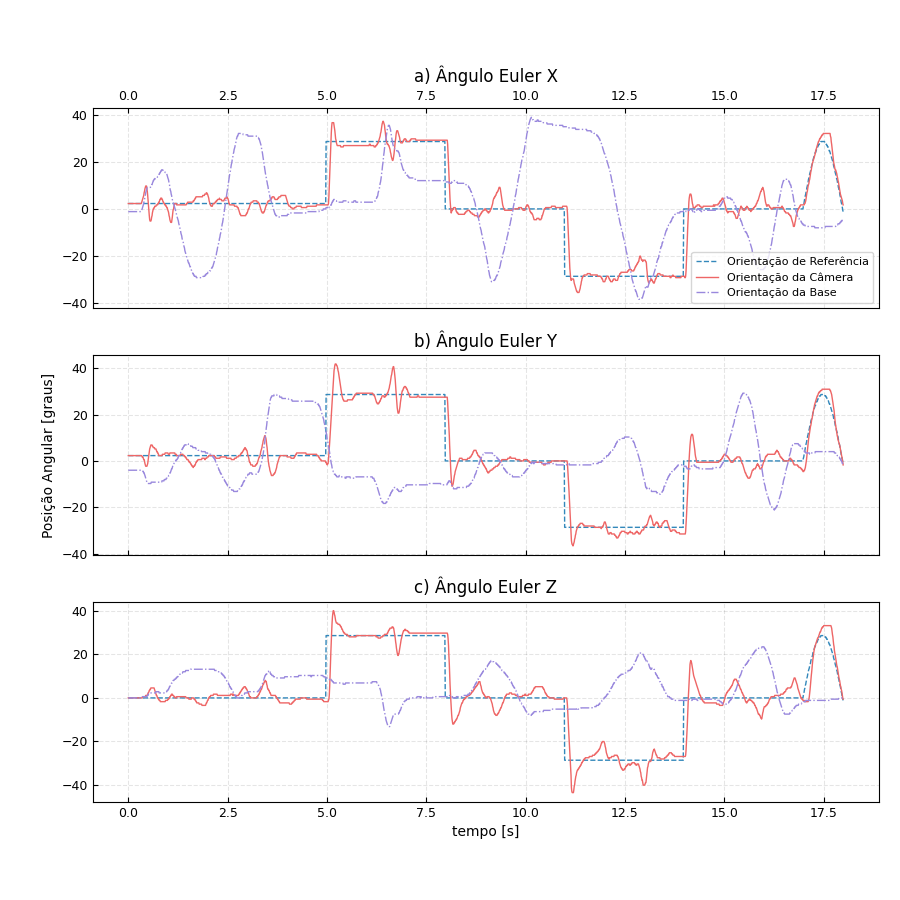

In [12]:
mosaic = [['yaw','yaw'],
['pit','pit'],
['rol','rol']]

fig,ax = plt.subplot_mosaic(mosaic)


ax['yaw'].set(title='a) Ângulo Euler X')
ax['yaw'].tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

ax['pit'].set(ylabel='Posição Angular [graus]', title='b) Ângulo Euler Y')
# ax['pit'].label_outer()

ax['rol'].set(title='c) Ângulo Euler Z',xlabel='tempo [s]')


for a in ax:
    ax[a].tick_params(direction='in', labelsize='9')
    ax[a].grid(which='major', alpha=0.1)
    ax[a].label_outer()

#------------------------------------------------------------------
file = 'curvas_1/orient_ref_disturb_PID.txt'

#roll pitch yaw
[r, p, y, r_d, p_d, y_d, r2, p2, y2, t] = np.loadtxt(file, unpack=True)


#alguns ponto antes da primeira mudança de ref
# start_point = find_start(r2) - 50
start_point = 0
t = t - t[start_point]  # inicia tempo com 0
i,j = cut(t,0,18)

[r, p, y, r_d, p_d, y_d, r2, p2, y2] = degree([r, p, y, r_d, p_d, y_d, r2, p2, y2])

ax['yaw'].plot(t[i:j],y2[i:j],'--')
ax['yaw'].plot(t[i:j],y[i:j],'-')
ax['yaw'].plot(t[i:j],y_d[i:j],'-.')

ax['pit'].plot(t[i:j],p2[i:j],'--')
ax['pit'].plot(t[i:j],p[i:j],'-')
ax['pit'].plot(t[i:j],p_d[i:j],'-.')

ax['rol'].plot(t[i:j],r2[i:j],'--')
ax['rol'].plot(t[i:j],r[i:j],'-')
ax['rol'].plot(t[i:j],r_d[i:j],'-.')

print(IDA(y[i:j],t[i:j]))

ax['yaw'].legend(['Orientação de Referência','Orientação da Câmera','Orientação da Base'],fontsize=8)

fig.tight_layout(h_pad=0)
fig.set_size_inches(9,9)
# plt.savefig("imagens/orient_PID.svg",pad_inches=0)

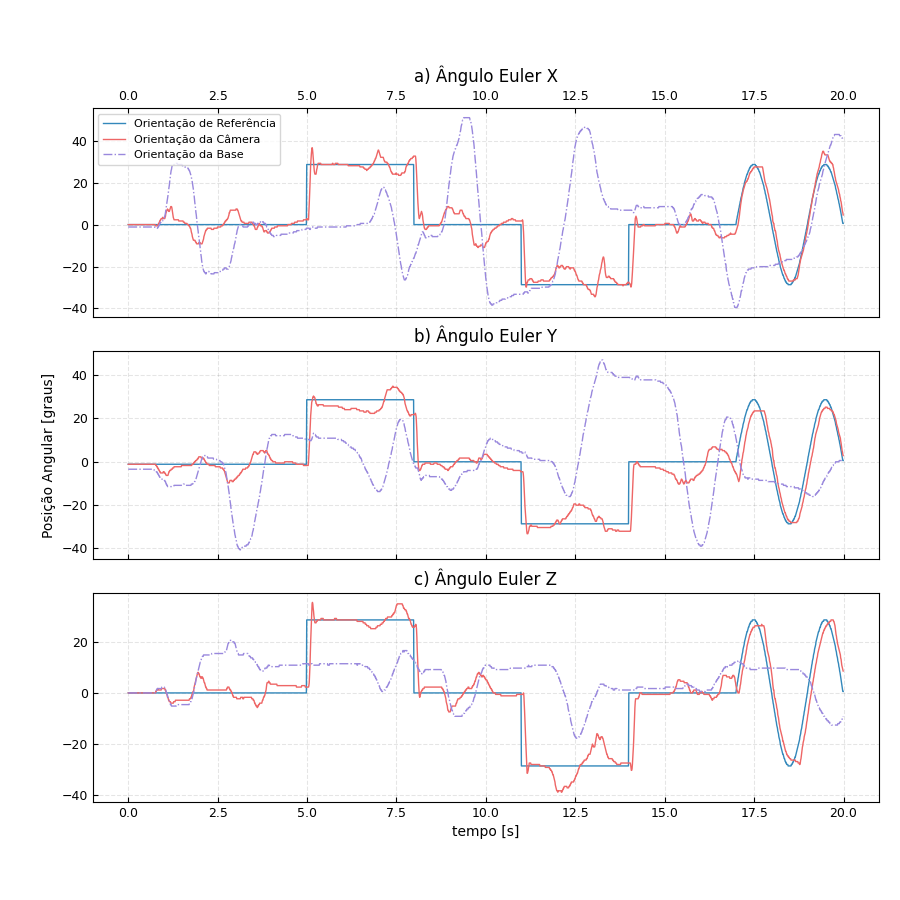

In [13]:
mosaic = [['yaw','yaw'],
['pit','pit'],
['rol','rol']]

fig,ax = plt.subplot_mosaic(mosaic)


ax['yaw'].set(title='a) Ângulo Euler X')
ax['yaw'].tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

ax['pit'].set(ylabel='Posição Angular [graus]', title='b) Ângulo Euler Y')
# ax['pit'].label_outer()

ax['rol'].set(title='c) Ângulo Euler Z',xlabel='tempo [s]')


for a in ax:
    ax[a].tick_params(direction='in', labelsize='9')
    ax[a].grid(which='major', alpha=0.1)
    ax[a].label_outer()

#------------------------------------------------------------------
file = 'curvas_1/orient_ref_disturb_PD.txt'

#roll pitch yaw
[r, p, y, r_d, p_d, y_d, r2, p2, y2, t] = np.loadtxt(file, unpack=True)


#alguns ponto antes da primeira mudança de ref
# start_point = find_start(r2) - 50
t = t - t[0]  # inicia tempo com 0
i,j = cut(t,0,20)

[r, p, y, r_d, p_d, y_d, r2, p2, y2] = degree([r, p, y, r_d, p_d, y_d, r2, p2, y2])

ax['yaw'].plot(t[i:j],y2[i:j],'-')
ax['yaw'].plot(t[i:j],y[i:j],'-')
ax['yaw'].plot(t[i:j],y_d[i:j],'-.')

ax['pit'].plot(t[i:j],p2[i:j],'-')
ax['pit'].plot(t[i:j],p[i:j],'-')
ax['pit'].plot(t[i:j],p_d[i:j],'-.')

ax['rol'].plot(t[i:j],r2[i:j],'-')
ax['rol'].plot(t[i:j],r[i:j],'-')
ax['rol'].plot(t[i:j],r_d[i:j],'-.')


ax['yaw'].legend(['Orientação de Referência','Orientação da Câmera','Orientação da Base'],fontsize=8)

fig.tight_layout(h_pad=-0.5)
fig.set_size_inches(9,9)
# plt.savefig("imagens/orient_PD.svg",pad_inches=0)

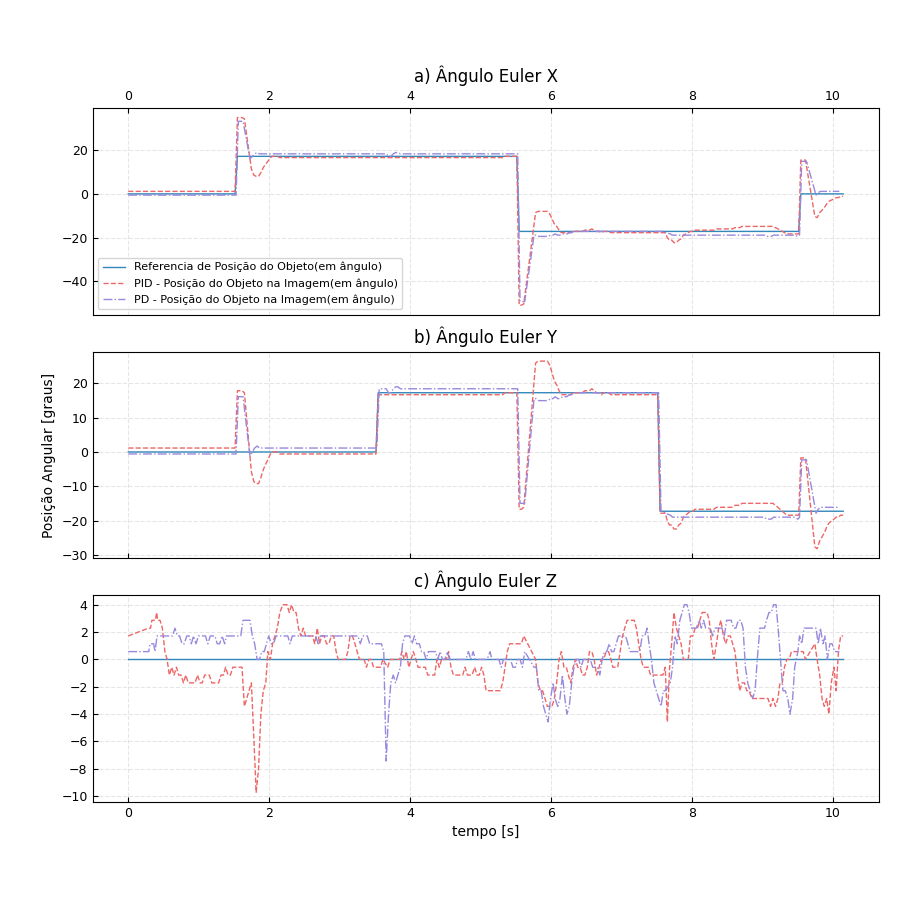

In [14]:
mosaic = [['yaw','yaw'],
['pit','pit'],
['rol','rol']]

fig,ax = plt.subplot_mosaic(mosaic)

ax['yaw'].set(title='a) Ângulo Euler X')
ax['yaw'].tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

ax['pit'].set(ylabel='Posição Angular [graus]', title='b) Ângulo Euler Y')
# ax['pit'].label_outer()

ax['rol'].set(title='c) Ângulo Euler Z',xlabel='tempo [s]')


for a in ax:
    ax[a].tick_params(direction='in', labelsize='9')
    ax[a].grid(which='major', alpha=0.1)
    ax[a].label_outer()

#------------------------------------------------------------------
file = 'curvas_1/visao_semdisturb_PID.txt'

#roll pitch yaw
[r, p, y, r_d, p_d, y_d, y2, p2, r2, t] = np.loadtxt(file, unpack=True)


#alguns ponto antes da primeira mudança de ref
# start_point = find_start(r2) - 50
t = t - t[0]  # inicia tempo com 0
i,j = cut(t,0,10)

#em vez de erro vamos visualizar a posição do objeto na tela
r_d = r2+r_d
p_d = p2+y_d
y_d = y2+y_d

[r, p, y, r_d, p_d, y_d, r2, p2, y2] = degree([r, p, y, r_d, p_d, y_d, r2, p2, y2])

ax['yaw'].plot(t[i:j],y2[i:j],'-')
ax['yaw'].plot(t[i:j],y_d[i:j],'--')
# ax['yaw'].plot(t[i:j],y[i:j],'-.')

ax['pit'].plot(t[i:j],p2[i:j],'-')
ax['pit'].plot(t[i:j],p_d[i:j],'--')
# ax['pit'].plot(t[i:j],p[i:j],'-.')

ax['rol'].plot(t[i:j],r2[i:j],'-')
ax['rol'].plot(t[i:j],r_d[i:j],'--')
# ax['rol'].plot(t[i:j],r[i:j],'-.')


file = 'curvas_1/visao_semdisturb_PD.txt'

#roll pitch yaw
[r, p, y, r_d, p_d, y_d, y2, p2, r2, t] = np.loadtxt(file, unpack=True)
t = t - t[0]  # inicia tempo com 0
i,j = cut(t,0,10)

r_d = r2+r_d
p_d = p2+y_d
y_d = y2+y_d

[r_d, p_d, y_d] = degree([r_d, p_d, y_d])

ax['pit'].plot(t[i:j],p_d[i:j],'-.')
ax['yaw'].plot(t[i:j],y_d[i:j],'-.')
ax['rol'].plot(t[i:j],r_d[i:j],'-.')


ax['yaw'].legend(['Referencia de Posição do Objeto(em ângulo)','PID - Posição do Objeto na Imagem(em ângulo)','PD - Posição do Objeto na Imagem(em ângulo)'],fontsize=8)
fig.tight_layout(h_pad=-0.5)
fig.set_size_inches(9,9)
# plt.savefig("imagens/visao_pid.svg",pad_inches=0)

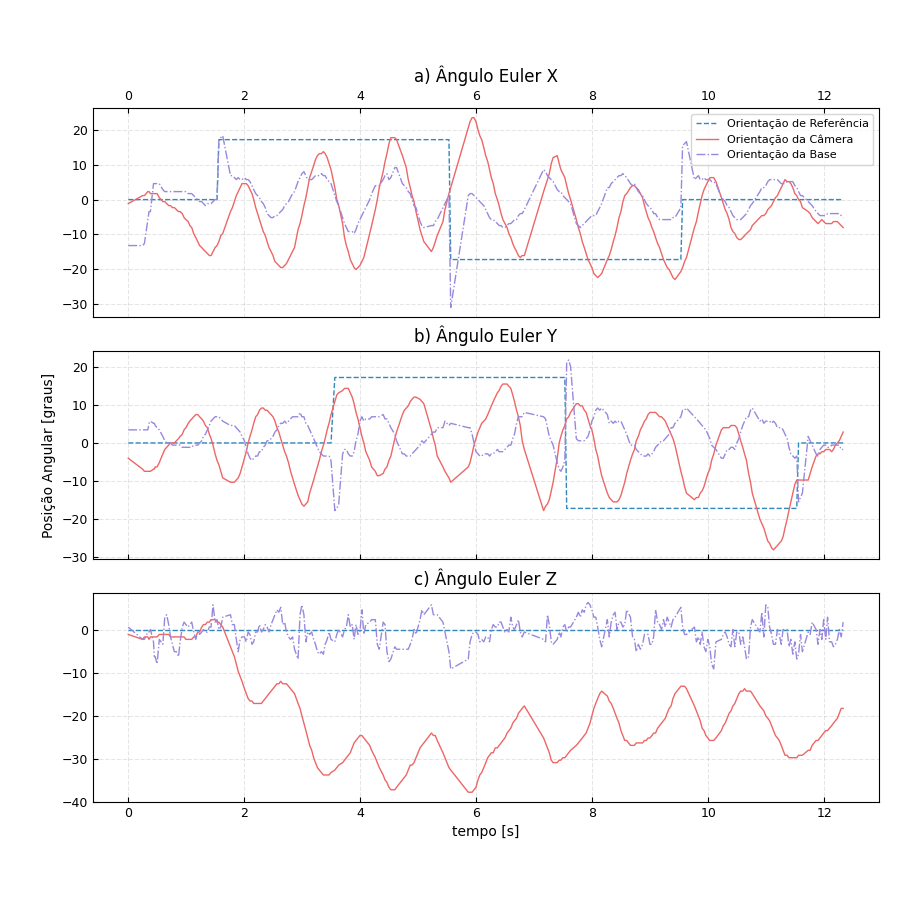

In [15]:
mosaic = [['yaw','yaw'],
['pit','pit'],
['rol','rol']]

fig,ax = plt.subplot_mosaic(mosaic)


ax['yaw'].set(title='a) Ângulo Euler X')
ax['yaw'].tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

ax['pit'].set(ylabel='Posição Angular [graus]', title='b) Ângulo Euler Y')
# ax['pit'].label_outer()

ax['rol'].set(title='c) Ângulo Euler Z',xlabel='tempo [s]')


for a in ax:
    ax[a].tick_params(direction='in', labelsize='9')
    ax[a].grid(which='major', alpha=0.1)
    ax[a].label_outer()

#------------------------------------------------------------------
file = 'curvas_1/visao_PD.txt'

#roll pitch yaw
[r, p, y, r_d, p_d, y_d, y2, p2, r2, t] = np.loadtxt(file, unpack=True)


#alguns ponto antes da primeira mudança de ref
# start_point = find_start(r2) - 50
t = t - t[0]  # inicia tempo com 0
i,j = cut(t,0,12)

[r, p, y, r_d, p_d, y_d, r2, p2, y2] = degree([r, p, y, r_d, p_d, y_d, r2, p2, y2])

ax['yaw'].plot(t[i:j],y2[i:j],'--')
ax['yaw'].plot(t[i:j],y[i:j],'-')
ax['yaw'].plot(t[i:j],y_d[i:j],'-.')

ax['pit'].plot(t[i:j],p2[i:j],'--')
ax['pit'].plot(t[i:j],p[i:j],'-')
ax['pit'].plot(t[i:j],p_d[i:j],'-.')

ax['rol'].plot(t[i:j],r2[i:j],'--')
ax['rol'].plot(t[i:j],r[i:j],'-')
ax['rol'].plot(t[i:j],r_d[i:j],'-.')


ax['yaw'].legend(['Orientação de Referência','Orientação da Câmera','Orientação da Base'],fontsize=8)

fig.tight_layout(h_pad=-0.5)
fig.set_size_inches(9,9)
# plt.savefig("imagens/orient_PD.svg",pad_inches=0)